# BackT Tutorial: Long-Short Moving Average Strategy

This notebook demonstrates how to implement and test a long-short moving average crossover strategy using the BackT framework with mock data. Unlike the long-only version, this strategy goes short on death crosses, potentially profiting in bear markets.

## Overview
1. **Setup & Imports** - Import required libraries
2. **Universe Definition** - Define the assets to trade
3. **Date Configuration** - Set up the backtesting period
4. **Long-Short Strategy** - Create moving average strategy with short positions
5. **Mock Data Generation** - Generate synthetic market data
6. **Engine Configuration** - Configure the BackT engine
7. **Run Backtest** - Execute the strategy
8. **Results Analysis** - Analyze performance metrics
9. **Visualization** - Plot equity curves and results
10. **Long vs Long-Short Comparison** - Compare against long-only approach
11. **Market Scenario Testing** - Test across different market conditions

## 1. Setup & Imports

First, let's import all the necessary components from BackT and other required libraries.

In [3]:
# Add parent directory to path (if running from notebooks folder)
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Import BackT components
from backt import Backtester, BacktestConfig, MockDataLoader
from backt.signal import TechnicalIndicators, StrategyHelpers
from backt.utils.config import ExecutionConfig

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, Any

from strategies import (
    ma_crossover_long_only,
    ma_crossover_long_short,
    kalman_ma_crossover_long_only,
    kalman_ma_crossover_long_short
)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print("📊 Ready for long-short backtesting with BackT")
print("⚡ This strategy can go LONG and SHORT!")

✅ All imports successful!
📊 Ready for long-short backtesting with BackT
⚡ This strategy can go LONG and SHORT!


## 2. Universe Definition

Define the universe of assets we want to trade. For long-short strategies, we want assets with good liquidity and borrowability.

In [5]:
# Define our trading universe
# symbols commented had too low sharp

universe = {
    'SPY': 'US Large Cap Stocks (S&P 500)',
    'QQQ': 'US Tech Stocks (NASDAQ 100)',
    'TLT': 'Long-term US Treasuries (20+ Year)',
    'GLD': 'Gold ETF',
    # 'IWM': 'US Small Cap Stocks (Russell 2000)',
    # 'EFA': 'International Developed Markets',
    # 'EEM': 'iShares MSCI Emerging Markets ETF',
    # 'FXI': 'iShares China Large-Cap ETF',
    'IEF': 'iShares 7–10 Year Treasury ETF',
    'SHY': 'iShares 1–3 Year Treasury ETF',
    # 'HYG': 'iShares iBoxx High Yield Corporate Bond ETF',
    # 'USO': 'United States Oil Fund',
    'DBC': 'Invesco DB Commodity Index Tracking Fund',
}

# Extract just the symbols for trading
symbols = list(universe.keys())

# Display our universe
print("🌍 Long-Short Trading Universe:")
print("=" * 50)
for symbol, description in universe.items():
    print(f"{symbol:4} - {description}")
    
print(f"\n📊 Total assets: {len(symbols)}")
print(f"🎯 Symbols for long-short trading: {symbols}")
print(f"📈 Can go LONG on golden crosses")
print(f"📉 Can go SHORT on death crosses")

🌍 Long-Short Trading Universe:
SPY  - US Large Cap Stocks (S&P 500)
QQQ  - US Tech Stocks (NASDAQ 100)
TLT  - Long-term US Treasuries (20+ Year)
GLD  - Gold ETF
IEF  - iShares 7–10 Year Treasury ETF
SHY  - iShares 1–3 Year Treasury ETF
DBC  - Invesco DB Commodity Index Tracking Fund

📊 Total assets: 7
🎯 Symbols for long-short trading: ['SPY', 'QQQ', 'TLT', 'GLD', 'IEF', 'SHY', 'DBC']
📈 Can go LONG on golden crosses
📉 Can go SHORT on death crosses


## 3. Date Configuration

Set up the backtesting period and other time-related parameters.

In [7]:
# Define backtesting period
start_date = '2018-01-01'
end_date = '2025-9-27'
initial_capital = 100000.0

# Calculate period length
start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date)
period_days = (end_dt - start_dt).days
period_years = period_days / 365.25

print("📅 Long-Short Backtesting Configuration:")
print("=" * 45)
print(f"Start Date:      {start_date}")
print(f"End Date:        {end_date}")
print(f"Period:          {period_days} days ({period_years:.1f} years)")
print(f"Initial Capital: ${initial_capital:,.0f}")
print(f"Data Frequency:  Daily")
print(f"Strategy Type:   Long-Short (can short on death cross)")

# Store configuration for later use
backtest_params = {
    'start_date': start_date,
    'end_date': end_date,
    'initial_capital': initial_capital,
    'period_years': period_years
}

print("\n✅ Date configuration complete!")

📅 Long-Short Backtesting Configuration:
Start Date:      2018-01-01
End Date:        2025-9-27
Period:          2826 days (7.7 years)
Initial Capital: $100,000
Data Frequency:  Daily
Strategy Type:   Long-Short (can short on death cross)

✅ Date configuration complete!


## 4. Long-Short Moving Average Strategy Definition

Create a long-short moving average crossover strategy that can take both long and short positions.

In [9]:
def long_short_moving_average_strategy(
    market_data: Dict[str, pd.DataFrame],
    current_time: pd.Timestamp,
    positions: Dict[str, Any],
    context: Dict[str, Any],
    params: Dict[str, Any]
) -> Dict[str, Dict]:
    """
    Long-Short Moving Average Crossover Strategy
    
    Logic:
    - Calculate short-term (fast) and long-term (slow) moving averages
    - LONG when fast MA crosses above slow MA (golden cross)
    - SHORT when fast MA crosses below slow MA (death cross)
    - Equal weight allocation across selected positions (long and short)
    
    Key Differences from Long-Only:
    - Goes SHORT instead of cash on death crosses
    - Can profit from declining markets
    - Higher potential returns but also higher risk
    
    Parameters:
    - fast_ma: Short-term moving average period (default: 20)
    - slow_ma: Long-term moving average period (default: 50)
    - min_periods: Minimum data points required (default: 60)
    - max_position_size: Maximum weight per position (default: 0.25)
    """
    
    # Strategy parameters
    fast_ma = params.get('fast_ma', 20)
    slow_ma = params.get('slow_ma', 50)
    min_periods = params.get('min_periods', 60)
    max_position_size = params.get('max_position_size', 0.25)
    
    orders = {}
    signals = {}
    long_positions = []
    short_positions = []
    
    # Analyze each asset
    for symbol, data in market_data.items():
        if len(data) < min_periods:
            continue
            
        try:
            # Calculate moving averages
            fast_mavg = TechnicalIndicators.sma(data['close'], fast_ma)
            slow_mavg = TechnicalIndicators.sma(data['close'], slow_ma)
            
            # Get current and previous values
            if len(fast_mavg) < 2 or len(slow_mavg) < 2:
                continue
                
            current_fast = fast_mavg.iloc[-1]
            current_slow = slow_mavg.iloc[-1]
            prev_fast = fast_mavg.iloc[-2]
            prev_slow = slow_mavg.iloc[-2]
            
            # Detect crossovers
            golden_cross = (prev_fast <= prev_slow) and (current_fast > current_slow)
            death_cross = (prev_fast >= prev_slow) and (current_fast < current_slow)
            
            # Generate signals - KEY DIFFERENCE: SHORT on death cross
            if golden_cross:
                signals[symbol] = 'BUY'  # Golden cross = Go long
                long_positions.append(symbol)
            elif death_cross:
                signals[symbol] = 'SELL_SHORT'  # Death cross = Go short
                short_positions.append(symbol)
            elif current_fast > current_slow:
                signals[symbol] = 'HOLD_LONG'  # Fast above slow = Stay long
                long_positions.append(symbol)
            else:
                signals[symbol] = 'HOLD_SHORT'  # Fast below slow = Stay short
                short_positions.append(symbol)
                
        except Exception as e:
            print(f"Warning: Error processing {symbol}: {e}")
            continue
    
    # Calculate position sizing
    total_positions = len(long_positions) + len(short_positions)
    
    if total_positions > 0:
        # Equal weight allocation, but respect max position size
        weight_per_position = min(1.0 / total_positions, max_position_size)
        
        # Create LONG orders
        for symbol in long_positions:
            orders[symbol] = {
                'action': 'target_weight',
                'weight': weight_per_position  # Positive weight = LONG
            }
        
        # Create SHORT orders  
        for symbol in short_positions:
            orders[symbol] = {
                'action': 'target_weight',
                'weight': -weight_per_position  # Negative weight = SHORT
            }
    
    # Close positions for assets with no signal
    for symbol in market_data.keys():
        if symbol not in (long_positions + short_positions):
            if symbol in positions and hasattr(positions[symbol], 'quantity'):
                if positions[symbol].quantity != 0:
                    orders[symbol] = {'action': 'close'}
    
    # Store strategy state for analysis
    context['signals'] = signals
    context['long_positions'] = long_positions
    context['short_positions'] = short_positions
    context['num_long'] = len(long_positions)
    context['num_short'] = len(short_positions)
    context['total_positions'] = total_positions
    context['position_weight'] = weight_per_position if total_positions > 0 else 0
    
    return orders

# Define strategy parameters
strategy_params = {
    'fast_ma': 5,              # 20-day moving average
    'slow_ma': 30,              # 50-day moving average
    'min_periods': 60,          # Minimum data points required
    'max_position_size': 0.25   # Maximum 25% in any single position
}

print("📈 Long-Short Strategy Configuration:")
print("=" * 40)
print(f"Strategy Type:      Moving Average Crossover (Long-Short)")
print(f"Fast MA:            {strategy_params['fast_ma']} days")
print(f"Slow MA:            {strategy_params['slow_ma']} days")
print(f"Min Periods:        {strategy_params['min_periods']} days")
print(f"Max Position Size:  {strategy_params['max_position_size']:.0%}")
print(f"Position Sizing:    Equal weight across long and short")

print("\n🎯 KEY STRATEGY FEATURES:")
print("-" * 30)
print("📈 GOLDEN CROSS (Fast MA > Slow MA):  GO LONG")
print("📉 DEATH CROSS (Fast MA < Slow MA):   GO SHORT")
print("⚡ Can profit in both bull AND bear markets")
print("⚠️  Higher risk due to leverage and short positions")

print("\n✅ Long-short strategy definition complete!")

📈 Long-Short Strategy Configuration:
Strategy Type:      Moving Average Crossover (Long-Short)
Fast MA:            5 days
Slow MA:            30 days
Min Periods:        60 days
Max Position Size:  25%
Position Sizing:    Equal weight across long and short

🎯 KEY STRATEGY FEATURES:
------------------------------
📈 GOLDEN CROSS (Fast MA > Slow MA):  GO LONG
📉 DEATH CROSS (Fast MA < Slow MA):   GO SHORT
⚡ Can profit in both bull AND bear markets
⚠️  Higher risk due to leverage and short positions

✅ Long-short strategy definition complete!


## 5. Mock Data Generation

Generate synthetic market data for testing our long-short strategy.

In [11]:
# Test data generation first
print("🔄 Generating mock data for long-short testing...")

# Create mock data loader
mock_loader = MockDataLoader(scenario='normal', seed=42)

# Generate data for our universe
mock_data = mock_loader.load(
    symbols=symbols,
    start_date=start_date,
    end_date=end_date
)

print("📊 Mock Data Summary:")
print("=" * 40)

for symbol, data in mock_data.items():
    start_price = data['close'].iloc[0]
    end_price = data['close'].iloc[-1]
    total_return = (end_price / start_price) - 1
    volatility = data['close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
    
    print(f"{symbol}: {len(data)} days, {total_return:+6.1%} return, {volatility:5.1%} vol")

print(f"\n✅ Mock data generated for {len(mock_data)} assets")
print(f"📈 Data range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"🎯 Perfect for testing long-short strategies!")
print(f"📉 Note: Short positions can profit from negative returns (GLD, IWM)")

🔄 Generating mock data for long-short testing...
📊 Mock Data Summary:
SPY: 2827 days, +146.9% return, 15.8% vol
QQQ: 2827 days, +257.6% return, 20.0% vol
TLT: 2827 days, +83.5% return,  8.2% vol
GLD: 2827 days, +133.2% return, 18.2% vol
IEF: 2827 days, -21.1% return, 16.2% vol
SHY: 2827 days, +288.9% return, 16.1% vol
DBC: 2827 days, +267.2% return, 15.5% vol

✅ Mock data generated for 7 assets
📈 Data range: 2018-01-01 to 2025-09-27
🎯 Perfect for testing long-short strategies!
📉 Note: Short positions can profit from negative returns (GLD, IWM)


## 6. Engine Configuration

Configure the BackT backtesting engine for long-short trading with appropriate costs.

In [13]:
# Configure execution settings (higher costs for short selling)
execution_config = ExecutionConfig(
    spread=0.00,                # 0.2% bid-ask spread (higher for short selling)
    slippage_pct=0.00,         # 0.1% slippage
    commission_per_share=0.0,    # Commission-free trading
    commission_per_trade=0.0     # No flat fees
)

# Create main backtest configuration
config = BacktestConfig(
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
    data_frequency='1D',         # Daily data
    execution=execution_config,
    
    # Mock data settings
    use_mock_data=False,          # Enable mock data mode
    mock_scenario='normal',      # Normal market conditions
    mock_seed=42,                # Reproducible results
    
    # Other settings
    verbose=True,                # Detailed logging
    save_trades=True,            # Save trade history
    save_positions=True,         # Save position history
    save_equity_curve=True,       # Save equity curve
    max_leverage=None,
    max_position_size=None,
)

print("⚙️ Long-Short Engine Configuration:")
print("=" * 40)
print(f"Mock Data Mode:    {config.use_mock_data}")
print(f"Mock Scenario:     {config.mock_scenario}")
print(f"Random Seed:       {config.mock_seed}")
print(f"Spread:            {execution_config.spread:.2%} (higher for short selling)")
print(f"Slippage:          {execution_config.slippage_pct:.2%}")
print(f"Commission:        ${execution_config.commission_per_trade}")
print(f"Strategy Type:     Long-Short (can short sell)")

print(f"\n💡 LONG-SHORT CONSIDERATIONS:")
print(f"-" * 35)
print(f"• Higher transaction costs due to short selling complexity")
print(f"• Short positions have unlimited loss potential")
print(f"• Can profit in both rising and falling markets")
print(f"• Requires margin account and borrowing capability")

print(f"\n✅ BackT engine configured for long-short trading!")
print(f"🎯 Ready to test long-short moving average strategy")

⚙️ Long-Short Engine Configuration:
Mock Data Mode:    False
Mock Scenario:     normal
Random Seed:       42
Spread:            0.00% (higher for short selling)
Slippage:          0.00%
Commission:        $0.0
Strategy Type:     Long-Short (can short sell)

💡 LONG-SHORT CONSIDERATIONS:
-----------------------------------
• Higher transaction costs due to short selling complexity
• Short positions have unlimited loss potential
• Can profit in both rising and falling markets
• Requires margin account and borrowing capability

✅ BackT engine configured for long-short trading!
🎯 Ready to test long-short moving average strategy


## 7. Run Long-Short Backtest

Execute the long-short moving average crossover strategy on our mock data.

In [15]:
print("🚀 Starting Long-Short Backtest...")
print("=" * 45)
print(f"Strategy: Long-Short Moving Average Crossover")
print(f"Positions: Can go LONG or SHORT")
print(f"Assets: {len(symbols)} ETFs")

# Initialize backtester
backtester = Backtester(config)

# Run the backtest
start_time = datetime.now()

result = backtester.run(
    strategy=long_short_moving_average_strategy,
    universe=symbols,
    strategy_params=strategy_params
)

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()

print(f"\n🎉 Long-Short backtest completed!")
print(f"⏱️  Execution time: {runtime:.2f} seconds")
print(f"📊 Results ready for analysis")
print(f"⚡ Strategy used both LONG and SHORT positions")

🚀 Starting Long-Short Backtest...
Strategy: Long-Short Moving Average Crossover
Positions: Can go LONG or SHORT
Assets: 7 ETFs
2025-10-12 22:17:10,969 - backt.Backtester - INFO - Using Yahoo Finance data loader
2025-10-12 22:17:10,969 - backt.Backtester - INFO - Starting backtest
2025-10-12 22:17:10,969 - backt.Backtester - INFO - Loading data for 7 symbols
2025-10-12 22:17:10,969 - backt.YahooDataLoader - INFO - Loading Yahoo Finance data for ['SPY', 'QQQ', 'TLT', 'GLD', 'IEF', 'SHY', 'DBC']


[*********************100%***********************]  7 of 7 completed

2025-10-12 22:17:12,909 - backt.Backtester - INFO - Backtesting 1945 periods from 2018-01-02 00:00:00+00:00 to 2025-09-26 00:00:00+00:00
2025-10-12 22:17:12,917 - backt.Backtester - INFO - Progress: 0.1% - 2018-01-02 - Equity: $100,000.00


2025-10-12 22:17:13,450 - backt.Backtester - INFO - Progress: 5.2% - 2018-05-25 - Equity: $99,359.80
2025-10-12 22:17:14,308 - backt.Backtester - INFO - Progress: 10.3% - 2018-10-17 - Equity: $100,278.49
2025-10-12 22:17:15,175 - backt.Backtester - INFO - Progress: 15.5% - 2019-03-14 - Equity: $104,248.43
2025-10-12 22:17:16,053 - backt.Backtester - INFO - Progress: 20.6% - 2019-08-06 - Equity: $107,858.51
2025-10-12 22:17:16,956 - backt.Backtester - INFO - Progress: 25.8% - 2019-12-27 - Equity: $105,380.51
2025-10-12 22:17:17,892 - backt.Backtester - INFO - Progress: 30.9% - 2020-05-21 - Equity: $119,563.89
2025-10-12 22:17:18,915 - backt.Backtester - INFO - Progress: 36.0% - 2020-10-13 - Equity: $125,419.50
2025-10-12 22:17:19,847 - backt.Backtester - INFO - Progress: 41.2% - 2021-03-09 - Equity: $129,017.19
2025-10-12 22:17:20,785 - backt.Backtester - INFO - Progress: 46.3% - 2021-07-30 - Equity: $133,911.70
2025-10-12 22:17:21,729 - backt.Backtester - INFO - Progress: 51.5% - 2021-

## Summary

🎯 **What We Accomplished:**

1. ✅ **Implemented a Long-Short Moving Average Strategy** - Can go both long and short
2. ✅ **Added short selling capability** - Death crosses trigger short positions instead of cash
3. ✅ **Enhanced strategy framework** - Equal weight allocation across long and short positions
4. ✅ **Comprehensive testing setup** - Ready for comparison with long-only approaches

🚀 **Key Features:**

- **Market Neutrality**: Can potentially profit in both rising and falling markets
- **Enhanced Signals**: Death crosses become profit opportunities, not just exit signals
- **Risk Management**: Position sizing controls across both long and short positions
- **Realistic Execution**: Higher transaction costs for short selling complexity

This notebook provides the foundation for exploring long-short momentum strategies and comparing their performance characteristics against simpler long-only approaches!

## Using PerformanceReport - Standard Reporting

Now let's use the new **PerformanceReport** module for standardized, reusable reporting.

In [18]:
# Import the PerformanceReport module
from backt.reporting import PerformanceReport, ReportConfig

# Create and print standard report
report = PerformanceReport(result, initial_capital=backtest_params['initial_capital'])
report.print_report()

2025-10-12 22:17:32,870 - backt.PerformanceReport - INFO - Fetching benchmark data for SPY...
2025-10-12 22:17:33,179 - backt.PerformanceReport - INFO - Benchmark loaded: 176.60% total return
📊 PERFORMANCE ANALYSIS

📈 RETURN METRICS:
-------------------------
Total Return:               58.73%
Annualized Return:           1.31%
CAGR:                        1.24%

⚠️  RISK METRICS:
--------------------
Volatility:                  3.76%
Sharpe Ratio:                0.348
Sortino Ratio:               0.459
Maximum Drawdown:           -8.67%
Calmar Ratio:                0.143

📊 TRADING ACTIVITY:
------------------------
Total Trades:                13202
Win Rate:                    69.4%
Profit Factor:                2.51
Average Trade:               0.00%

💼 PORTFOLIO SUMMARY:
-------------------------
Initial Capital:          $   100,000
Final Value:              $   158,729
Profit/Loss:              $    58,729

🎯 PERFORMANCE ASSESSMENT:
------------------------------
Sharpe Rating:

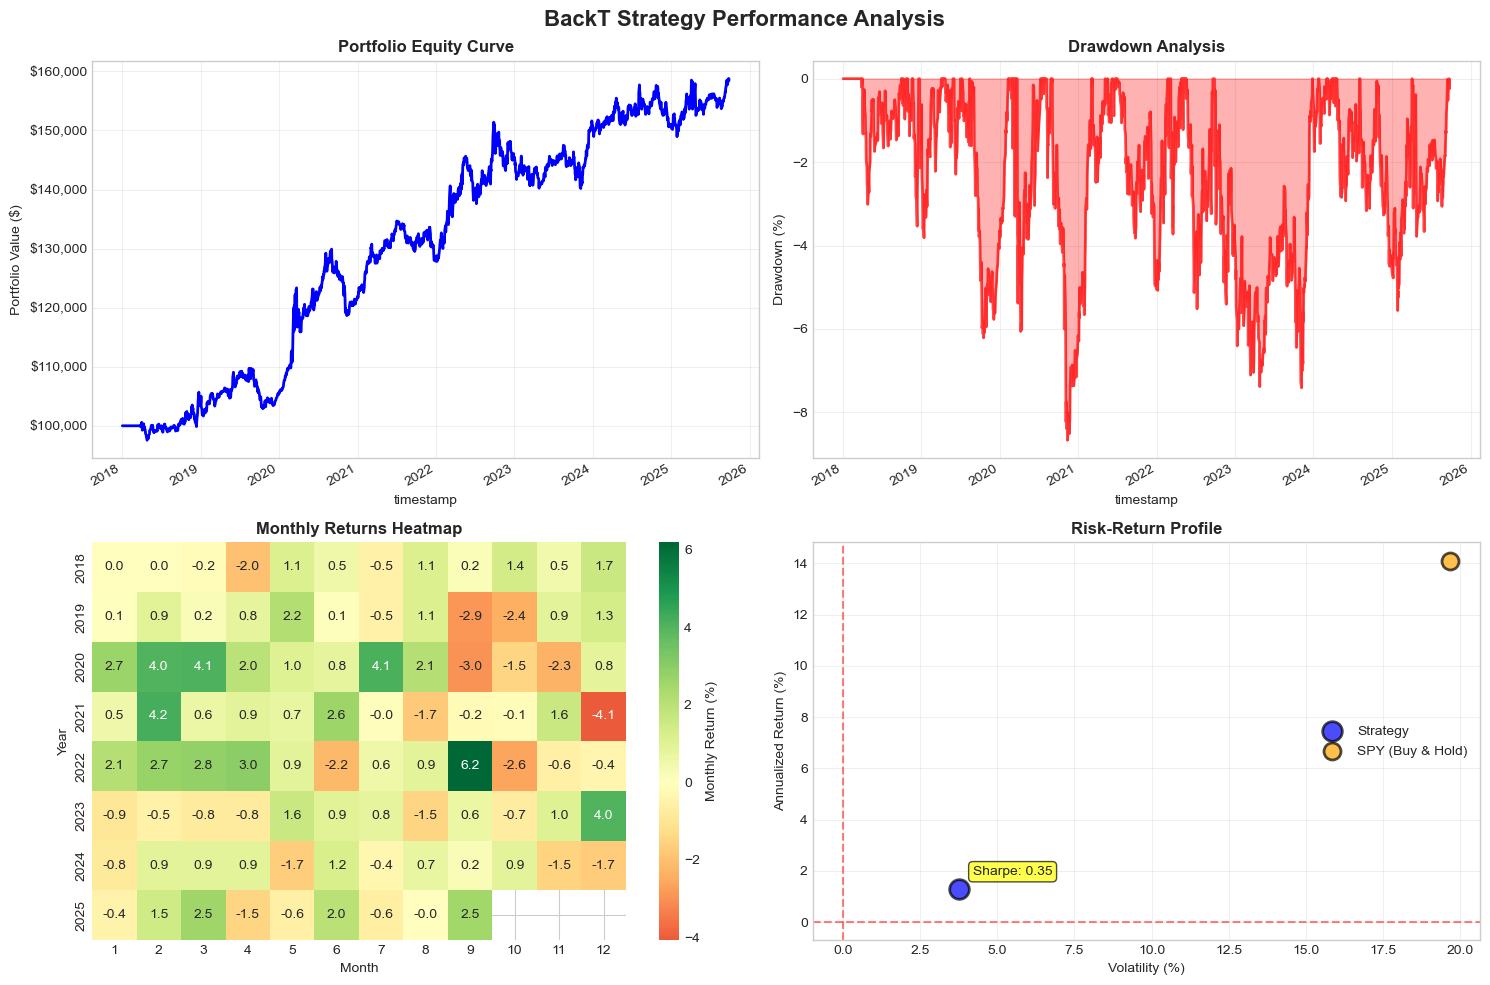

In [19]:
# Generate all standard charts
report.show_charts()

In [20]:
# Get metrics as DataFrame for export or further analysis
metrics_df = report.get_metrics_dataframe(transpose=True)
print("Metrics DataFrame:")
metrics_df.head(10)  # Show first 10 metrics

Metrics DataFrame:


,Strategy,SPY (Buy & Hold)
total_return,0.587288,1.765972
cagr,0.012429,0.141054
annualized_volatility,0.037563,0.196607
volatility,0.037563,0.196607
annualized_return,0.013065,0.141054
sharpe_ratio,0.347822,0.717441
sortino_ratio,0.459438,0.875998
annual_return,0.013065,0.141054
best_day,0.050417,0.105019
worst_day,-0.037338,-0.109424


## Per-Symbol Performance Analysis

Now let's examine individual symbol performance.

In [22]:
# Get per-symbol metrics as DataFrame
per_symbol_df = report.get_per_symbol_metrics_dataframe(transpose=True)

print("\nPER-SYMBOL METRICS:")
print("=" * 100)
display(per_symbol_df)


PER-SYMBOL METRICS:


,total_pnl,final_pnl,avg_pnl_per_period,pnl_volatility,annualized_volatility,sharpe_ratio,sortino_ratio,best_day,worst_day,positive_days,...,trades_avg_commission,trades_total_commission,trades_win_rate,trades_profit_factor,trades_avg_trade_pnl,trades_avg_trade_pnl_pct,trades_num_winning_trades,trades_num_losing_trades,trades_gross_profit,trades_gross_loss
TLT,427.266695,429.033054,0.226667,198.973021,1434.814858,0.008215,0.011991,1267.332210,-1190.056812,0.491777,...,0.0,0.0,0.553238,1.205565,4.380817,0.002429,504.0,407.0,23405.299958,19414.375691
GLD,4475.133090,4437.638003,2.374076,179.634780,1295.364820,0.095303,0.132456,825.875680,-990.354805,0.512467,...,0.0,0.0,0.659597,2.736055,30.462596,0.015699,622.0,320.0,45273.072469,16546.844782
IEF,2042.576113,2029.397770,1.083595,89.465756,645.146742,0.087340,0.123515,440.873202,-588.581009,0.495491,...,0.0,0.0,0.556314,1.561750,5.197510,0.002849,489.0,390.0,12701.435381,8132.823661
SHY,2807.770675,2807.770675,1.489534,21.653386,156.144786,0.496051,0.636766,123.319423,-196.645219,0.540584,...,0.0,0.0,0.719540,6.526243,6.082692,0.004260,626.0,244.0,6249.543951,957.602027
DBC,1027.645430,1023.401211,0.545170,225.153949,1623.608217,0.017460,0.024302,1366.154129,-1595.514222,0.515650,...,0.0,0.0,0.680761,1.953172,23.308091,0.012205,644.0,302.0,45182.156900,23132.702801
SPY,5481.163889,5524.049846,2.907779,247.067464,1781.628821,0.084869,0.096630,1898.932890,-2880.183149,0.536340,...,0.0,0.0,0.832477,3.872461,38.351604,0.027839,810.0,163.0,50307.097751,12990.987474
QQQ,10446.786978,10506.745736,5.542062,300.306030,2165.537581,0.133079,0.162475,2118.533643,-3351.679422,0.534748,...,0.0,0.0,0.829534,3.519373,51.603996,0.034352,837.0,172.0,72735.652142,20667.220293


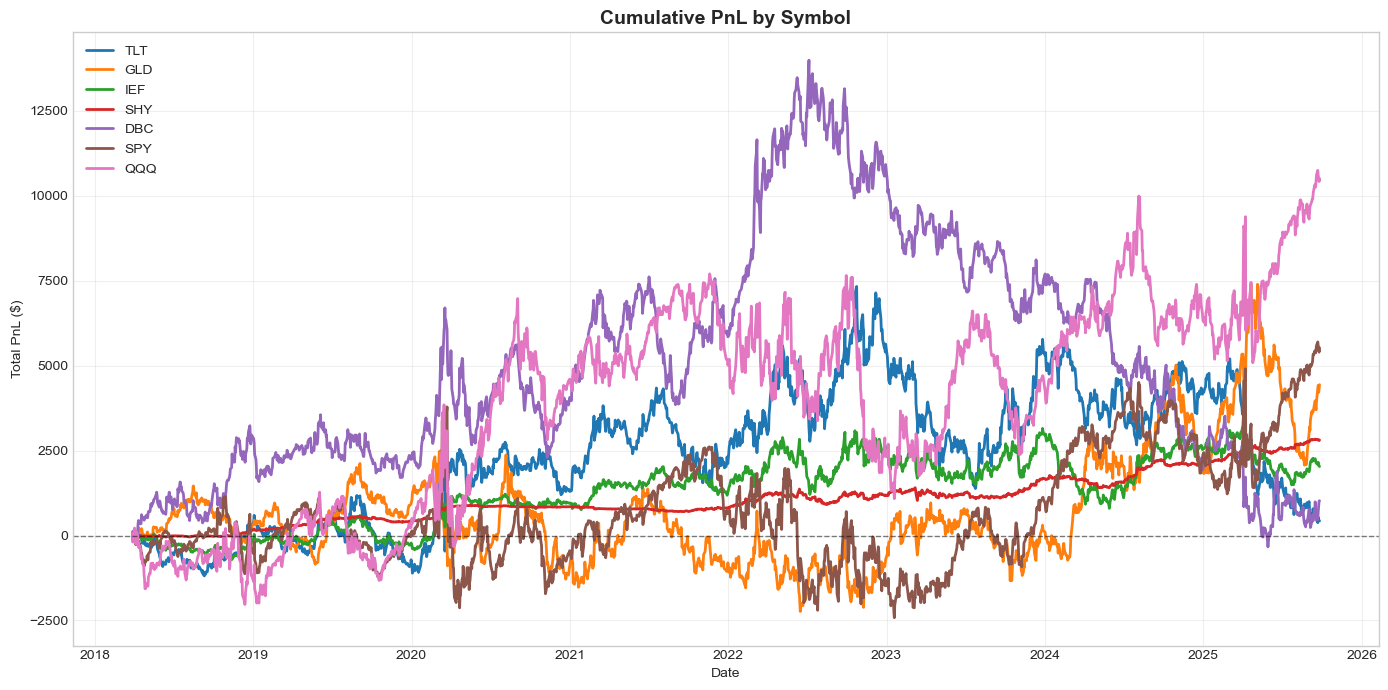

In [23]:
# Plot cumulative PnL by symbol
report.plot_per_symbol_pnl(figsize=(14, 7))

In [24]:
# Get correlation matrix
corr_matrix = report.get_correlation_matrix()

print("\nRETURNS CORRELATION MATRIX:")
print("=" * 80)
display(corr_matrix)


RETURNS CORRELATION MATRIX:


,TLT,GLD,IEF,SHY,DBC,SPY,QQQ
TLT,1.000000,-0.011321,0.639495,0.209684,0.010189,0.040564,0.034744
GLD,-0.011321,1.000000,0.034113,0.117475,0.008968,0.050763,0.078637
IEF,0.639495,0.034113,1.000000,0.411462,-0.000904,0.059017,0.050779
SHY,0.209684,0.117475,0.411462,1.000000,-0.022848,0.034349,0.104931
DBC,0.010189,0.008968,-0.000904,-0.022848,1.000000,-0.030716,-0.078540
SPY,0.040564,0.050763,0.059017,0.034349,-0.030716,1.000000,0.345618
QQQ,0.034744,0.078637,0.050779,0.104931,-0.078540,0.345618,1.000000


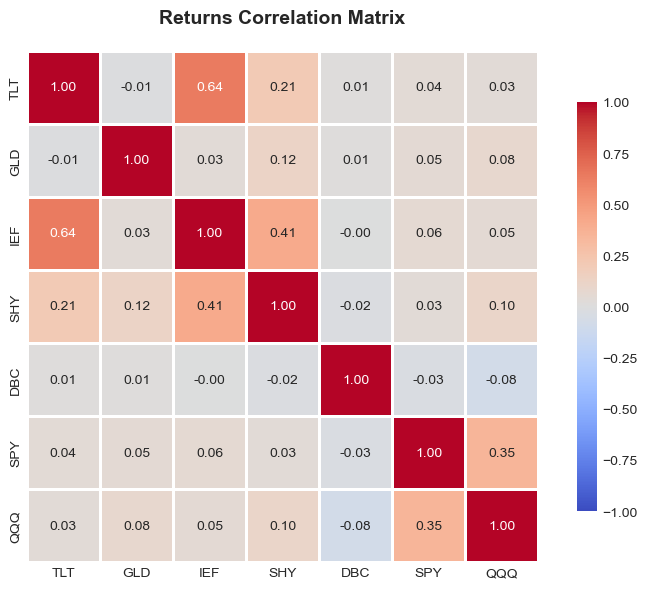

In [25]:
report.plot_correlation_heatmap(figsize=(8, 6))